# Telco Customer Churn - Python Analysis
### Main Objective:
1. Exploratory Data Anlaysis
2. Data Pre-processing
3. Model Building
4. Model Evaluation
---

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import mysql.connector
from mysql.connector import Error

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report

#### Load the data

In [2]:
# DB Config
db_config = {
    'host': 'localhost',
    'user': 'root',
    'password': 'root',
    'database': 'telco_churn'
}

In [3]:
# SQL Query to load the data
sql_query = """
SELECT
    c.customerID,
    c.gender,
    c.SeniorCitizen,
    c.Partner,
    c.Dependents,
    a.tenure,
    a.Contract,
    a.PaperlessBilling,
    a.PaymentMethod,
    a.MonthlyCharges,
    a.TotalCharges,
    s.PhoneService,
    s.MultipleLines,
    s.InternetService,
    s.OnlineSecurity,
    s.OnlineBackup,
    s.DeviceProtection,
    s.TechSupport,
    s.StreamingTV,
    s.StreamingMovies,
    ch.Churn
FROM
    customers c
JOIN
    account_info a ON c.customerID = a.customerID
JOIN
    services s ON c.customerID = s.customerID
JOIN
    churn_data ch ON c.customerID = ch.customerID;
"""

# Connect to the database and load the data
# Create a variable 'df' to hold the data
df = None
conn = None # Initialize connection to None

try:
    # Establish the connection
    conn = mysql.connector.connect(**db_config)
    
    if conn.is_connected():
        print("Successfully connected to the MySQL database.")
        
        # Use pandas to execute the query and load data into a DataFrame
        df = pd.read_sql(sql_query, conn)
        
        print("Data successfully loaded into a pandas DataFrame.")

except Error as e:
    print(f"Error connecting to MySQL or fetching data: {e}")

finally:
    # Make sure to close the connection
    if conn and conn.is_connected():
        conn.close()
        print("MySQL connection is closed.")

Successfully connected to the MySQL database.
Data successfully loaded into a pandas DataFrame.
MySQL connection is closed.


C:\Users\dkpc2\AppData\Local\Temp\ipykernel_18872\3995519853.py:48: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, conn)


In [4]:
# Check if the dataset is loaded properly
if df is not None:
    print("\n--- Data Verification ---")
    
    # Check the number of rows and columns loaded
    # This should show approximately (7043, 21)
    print(f"The DataFrame has {df.shape[0]} rows and {df.shape[1]} columns.")
    
    # Display the first 5 rows to see what the data looks like
    print("\nFirst 5 rows of the dataset:")
    display(df.head())
    
    # Display summary info to check for null values and data types
    print("\nDataFrame Info:")
    df.info()


--- Data Verification ---
The DataFrame has 7043 rows and 21 columns.

First 5 rows of the dataset:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,...,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Churn
0,0002-ORFBO,Female,0,Yes,Yes,9,One year,Yes,Mailed check,65.6,...,Yes,No,DSL,No,Yes,No,Yes,Yes,No,No\r
1,0003-MKNFE,Male,0,No,No,9,Month-to-month,No,Mailed check,59.9,...,Yes,Yes,DSL,No,No,No,No,No,Yes,No\r
2,0004-TLHLJ,Male,0,No,No,4,Month-to-month,Yes,Electronic check,73.9,...,Yes,No,Fiber optic,No,No,Yes,No,No,No,Yes
3,0011-IGKFF,Male,1,Yes,No,13,Month-to-month,Yes,Electronic check,98.0,...,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
4,0013-EXCHZ,Female,1,Yes,No,3,Month-to-month,Yes,Mailed check,83.9,...,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Yes



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   Contract          7043 non-null   object 
 7   PaperlessBilling  7043 non-null   object 
 8   PaymentMethod     7043 non-null   object 
 9   MonthlyCharges    7043 non-null   float64
 10  TotalCharges      7032 non-null   float64
 11  PhoneService      7043 non-null   object 
 12  MultipleLines     7043 non-null   object 
 13  InternetService   7043 non-null   object 
 14  OnlineSecurity    7043 non-null   object 
 15  OnlineBackup      7043 non-null   object 
 16  DeviceProtection  7043 no

#### Initial Profiling

In [5]:
missing_val = df.isna().sum()
missing_val

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Churn                0
dtype: int64

There's 11 missing values on TotalCharges column. We will drop the missing values.

In [6]:
df = df.dropna(axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   Contract          7032 non-null   object 
 7   PaperlessBilling  7032 non-null   object 
 8   PaymentMethod     7032 non-null   object 
 9   MonthlyCharges    7032 non-null   float64
 10  TotalCharges      7032 non-null   float64
 11  PhoneService      7032 non-null   object 
 12  MultipleLines     7032 non-null   object 
 13  InternetService   7032 non-null   object 
 14  OnlineSecurity    7032 non-null   object 
 15  OnlineBackup      7032 non-null   object 
 16  DeviceProtection  7032 non-null   object 
 17  

In [7]:
# Check duplicate
df.duplicated().sum()

np.int64(0)

No duplicate found on the dataset.

#### Exploratory Data Analysis
We will conduct:
1. Check customer's gender distribution
2. Check customer's internet service type distribution
3. Check customer's contract type
4. Check customer's churn rate by Contract type
5. Check customer's average MonthlyCharges for customers who churned vs. those who didn't
6. Check customer's churn rate by Internet Service type

In [8]:
# Gender distribution
cust_gender = df.groupby('gender')[['gender']].count()
cust_gender = cust_gender.rename(columns={
    'gender' : 'Count of gender'
}).reset_index()
cust_gender

,gender,Count of gender
0,Female,3483
1,Male,3549


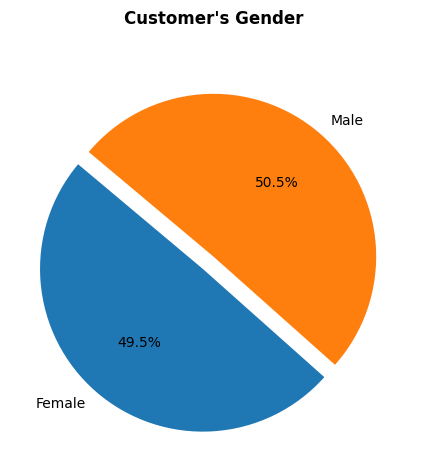

In [9]:
# Customer's gender chart
plt.pie(x='Count of gender', labels='gender', data=cust_gender, explode=[0.1, 0], autopct='%1.1f%%', startangle=140)
plt.title("Customer's Gender\n", weight='bold')
plt.tight_layout()
plt.show()

In [10]:
# Distribution of internet services
internet_services = df.groupby('InternetService')[['InternetService']].count()
internet_services = internet_services.rename(columns={
    'InternetService' : 'Count of Internet Service'
}).sort_values(by='Count of Internet Service', ascending=False).reset_index()
internet_services

,InternetService,Count of Internet Service
0,Fiber optic,3096
1,DSL,2416
2,No,1520


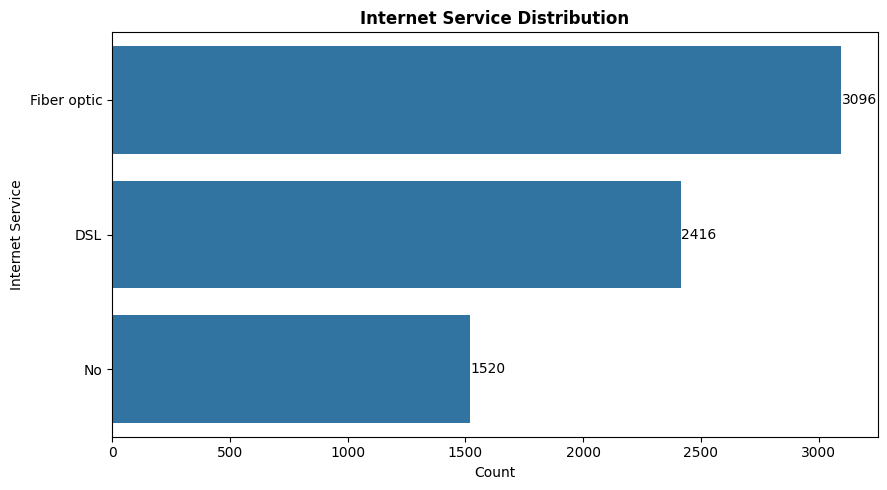

In [11]:
# Distribution of internet services plot
plt.figure(figsize=(9, 5))
ax = sns.barplot(x='Count of Internet Service', y='InternetService', data=internet_services)

# Add data labels
for i in ax.patches:
    ax.text(
        i.get_width() + 1,              
        i.get_y() + i.get_height() / 2,  
        int(i.get_width()),               
        ha='left', va='center'            
    )

# Add title, labels
plt.title('Internet Service Distribution', weight='bold')
plt.xlabel('Count')
plt.ylabel('Internet Service')
plt.tight_layout()
plt.show()

In [12]:
# Customers per contract type
cust_contract = df.groupby('Contract')[['Contract']].count()
cust_contract = cust_contract.rename(columns={
    'Contract' : 'Count of Contract'
}).sort_values(by='Count of Contract', ascending=False).reset_index()
cust_contract

,Contract,Count of Contract
0,Month-to-month,3875
1,Two year,1685
2,One year,1472


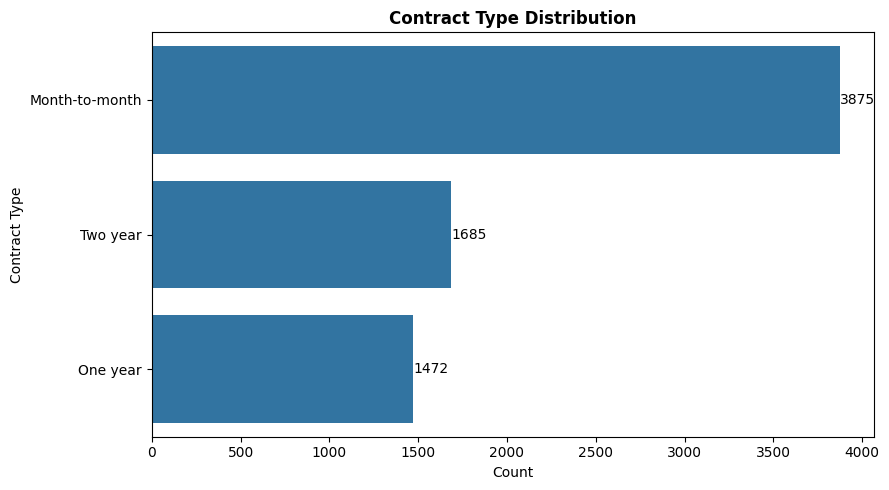

In [13]:
# Customers per contract types plot
plt.figure(figsize=(9, 5))
ax = sns.barplot(x='Count of Contract', y='Contract', data=cust_contract)

# Add data labels
for i in ax.patches:
    ax.text(
        i.get_width() + 1,              
        i.get_y() + i.get_height() / 2,  
        int(i.get_width()),               
        ha='left', va='center'            
    )

# Add title, labels
plt.title('Contract Type Distribution', weight='bold')
plt.xlabel('Count')
plt.ylabel('Contract Type')
plt.tight_layout()
plt.show()

In [14]:
# Analyze the churn rate by Contract type
churn_by_contract = (
    df.groupby('Contract').agg(
        total_customers=('customerID', 'count'),
        churned_customers=('Churn', lambda x: (x == 'Yes').sum())
    )
    .assign(churn_rate_percent=lambda x: np.round(x['churned_customers'] * 100 / x['total_customers'], 2))
    .sort_values('churn_rate_percent', ascending=False)
    .reset_index()
)

churn_by_contract

,Contract,total_customers,churned_customers,churn_rate_percent
0,Month-to-month,3875,1655,42.71
1,One year,1472,166,11.28
2,Two year,1685,48,2.85


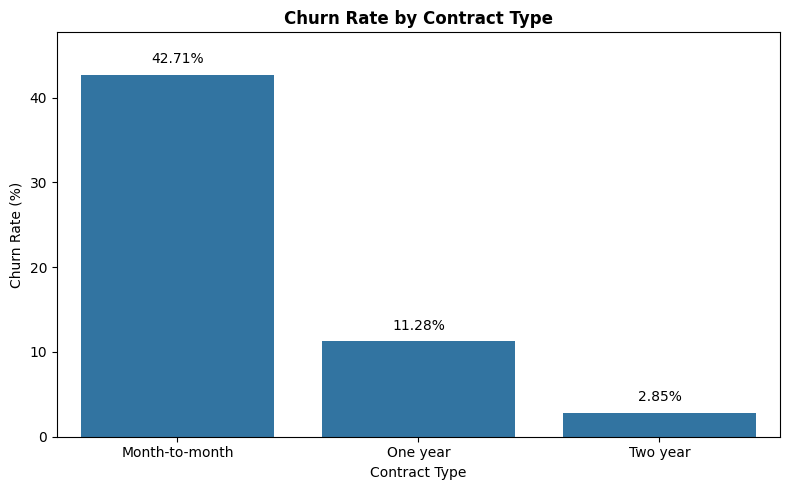

In [15]:
# Churn rate by Contract type plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Contract', y='churn_rate_percent', data=churn_by_contract)

# Add data labels
for bar in ax.patches:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f"{bar.get_height():.2f}%",
        ha='center', va='bottom'
    )

plt.title('Churn Rate by Contract Type', weight='bold')
plt.ylabel('Churn Rate (%)')
plt.xlabel('Contract Type')
plt.ylim(0, max(churn_by_contract['churn_rate_percent']) + 5) 
plt.tight_layout()
plt.show()

In [ ]:
#Investigate the average MonthlyCharges for customers who churned vs. those who didn't
avg_monthlyCharges = df.groupby(['Churn'])[['MonthlyCharges']].mean().reset_index()
avg_monthlyCharges['MonthlyCharges'] = np.round(avg_monthlyCharges['MonthlyCharges'], 2)
avg_monthlyCharges

,Churn,MonthlyCharges
0,No\r,61.31
1,Yes,74.44


) missing from font(s) DejaVu Sans.pykernel_18872\668416781.py:18: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from font(s) DejaVu Sans.\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


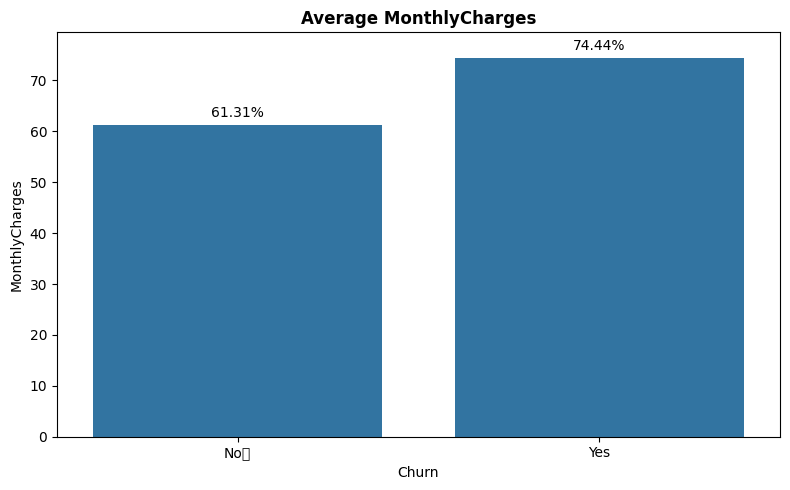

In [17]:
# Average MonthlyCharges for customers who churned vs. those who didn't plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Churn', y='MonthlyCharges', data=avg_monthlyCharges)

# Add data labels
for bar in ax.patches:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f"{bar.get_height():.2f}%",
        ha='center', va='bottom'
    )

plt.title('Average MonthlyCharges', weight='bold')
plt.ylabel('MonthlyCharges')
plt.xlabel('Churn')
plt.ylim(0, max(avg_monthlyCharges['MonthlyCharges']) + 5)
plt.tight_layout()
plt.show()

In [18]:
# Analyze the churn rate by Internet Service type
churn_by_serviceType = (
    df.groupby('InternetService').agg(
        total_customers=('customerID', 'count'),
        churned_customers=('Churn', lambda x: (x == 'Yes').sum())
    )
    .assign(churn_rate_percent=lambda x: np.round(x['churned_customers'] * 100 / x['total_customers'], 2))
    .sort_values('churn_rate_percent', ascending=False)
    .reset_index()
)
churn_by_serviceType

,InternetService,total_customers,churned_customers,churn_rate_percent
0,Fiber optic,3096,1297,41.89
1,DSL,2416,459,19.00
2,No,1520,113,7.43


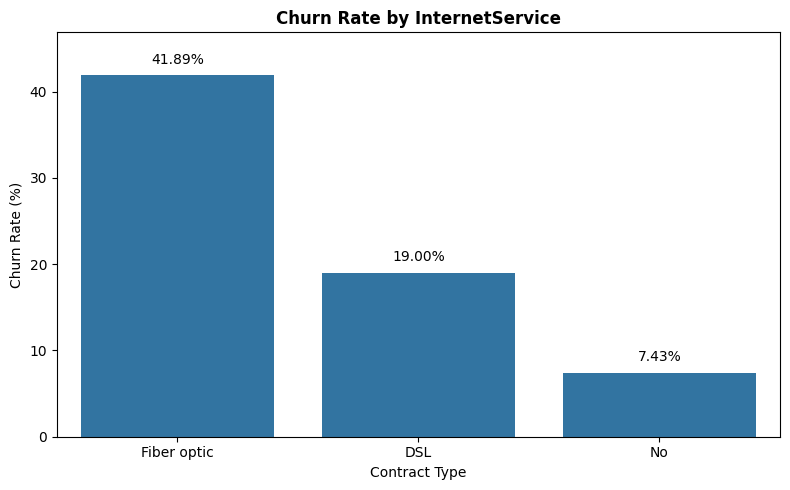

In [ ]:
# Churn rate by Internet Service type Plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='InternetService', y='churn_rate_percent', data=churn_by_serviceType)

# Add data labels
for bar in ax.patches:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f"{bar.get_height():.2f}%",
        ha='center', va='bottom'
    )

plt.title('Churn Rate by InternetService', weight='bold')
plt.ylabel('Churn Rate (%)')
plt.xlabel('Contract Type')
plt.ylim(0, max(churn_by_serviceType['churn_rate_percent']) + 5)
plt.tight_layout()
plt.show()

---

#### Data Pre-processing

We will conduct:
- Handle any remaining missing values (If there's any)
- Encode categorical variables
- Scale numerical features